# **Исследование скрытого пространства для сгенерированных изображений**

## Загрузка модели

{'bsize': 128, 'imsize': 64, 'nc': 3, 'nz': 100, 'ngf': 64, 'ndf': 64, 'nepochs': 10, 'lr': 0.0002, 'beta1': 0.5, 'save_epoch': 2}
Generator(
  (tconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


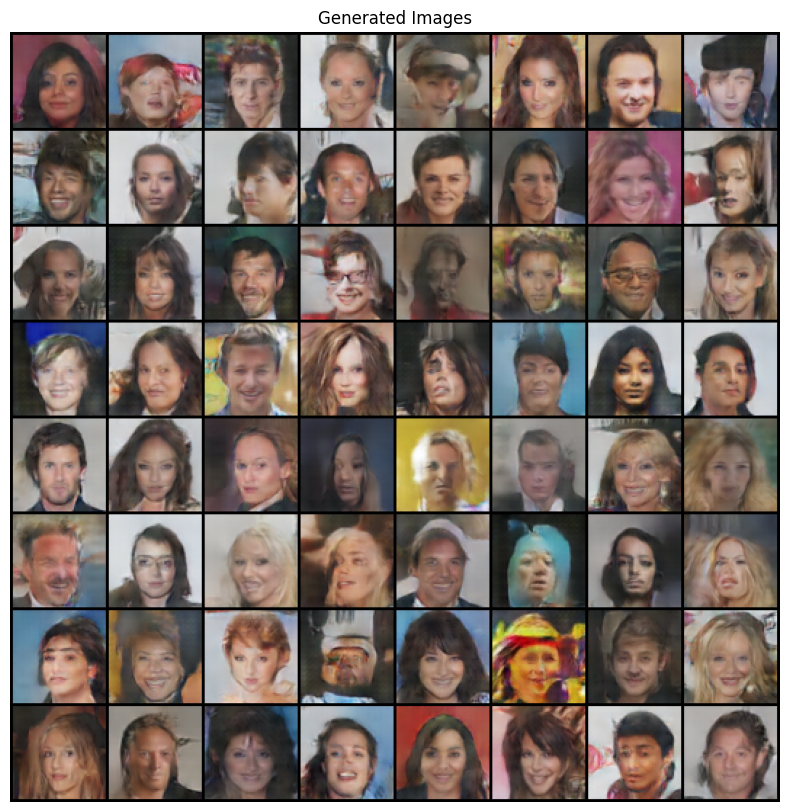

In [5]:
import torch
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

from dcgan import Generator

device = torch.device("cuda" if(torch.cuda.is_available()) else "cpu")

# Загрузка чекпоинта
state_dict = torch.load('./model_final.pth', map_location=device)

# Выделим параметры модели в отдельную переменную 
params = state_dict['params']

print(params)

# Генератор
netG = Generator(params).to(device)
# Загрузка весов генератора
netG.load_state_dict(state_dict['generator'])
print(netG)

# Получим латентный вектор из равномерного нормального распределения
noise = torch.randn(64, params['nz'], 1, 1, device=device)


with torch.no_grad():
	# Получим сгенерированное изображение
    generated_img = netG(noise).detach().cpu()

    # Скейлинг от[-1,1] к [0,1]
    generated_img = (generated_img+ 1) / 2.0

# Выведим на экран сгенерированное изображение
plt.figure(figsize = (10,10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True), (1, 2, 0)))

Создаются 64 случайных точки в 100-мерном скрытом пространстве, используемые моделью генератора для генерации 64 изображений лиц, которые затем наносятся на сетку 8 × 8.

## Интерполяция между лицами

Мы можем создать путь интерполяции между двумя точками в скрытом пространстве и сгенерировать лица  вдоль этого пути.

Простейшая интерполяция, которую мы можем использовать, - это линейная или равномерная интерполяция между двумя точками в скрытом пространстве.  

Функция `get_interpolations()` возвращает линейно интерполированные вектора между двумя точками в скрытом пространстве, включая первую и последнюю точку.

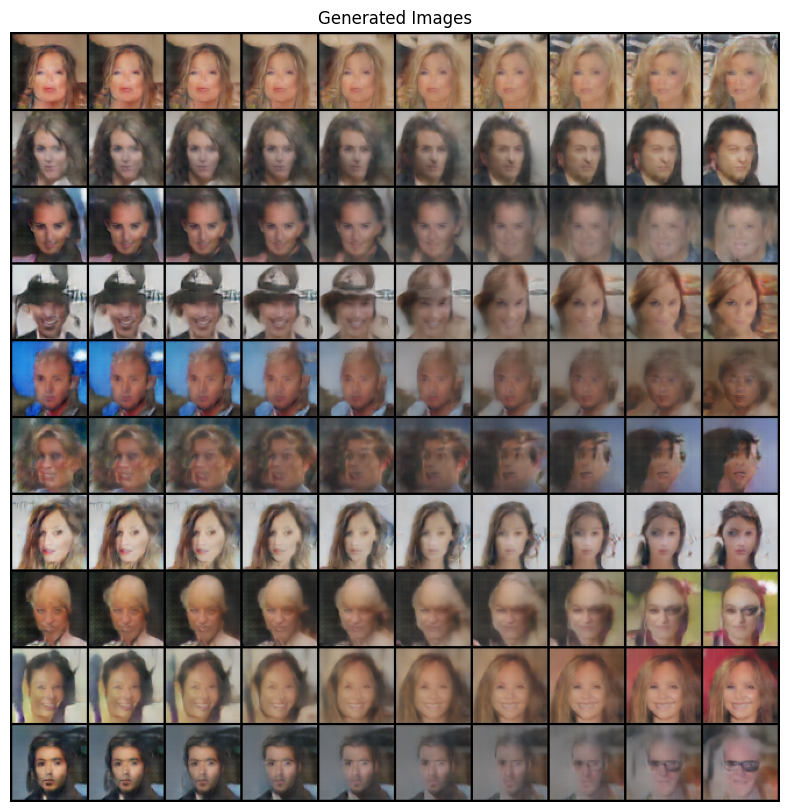

In [3]:
# Функция, возвращающая линейно интерполированные вектора между
# двумя точками в скрытом пространстве
# def get_interpolations(noise1, noise2, num_interpolates):
#     x = [((1.0 - (i/num_interpolates)) * noise1) + ((i/num_interpolates) * noise2) for i in range(num_interpolates + 1)]
#     return torch.cat(x, dim = 0)

# Функция, возвращающая линейно интерполированные вектора между
# произвольно заданным числом точек в скрытом пространстве
def get_interpolations(noises, num_interpolates):
    num_points = len(noises)
    # Создаем список, чтобы хранить результаты интерполяции
    interpolated_points = []
    
    # Проходим по каждому шагу интерполяции
    for i in range(num_interpolates + 1):
        alpha = i / num_interpolates
        # Линейная интерполяция между первым и последним шумом
        interpolated_point = sum((1 - alpha) * noises[0] + alpha * noise for noise in noises[1:]) / num_points
        interpolated_points.append(interpolated_point)
    
    return torch.cat(interpolated_points, dim=0)


def get_noises(N):
    noises = []
    for _ in range(N):
        noises.append(torch.randn(1, params['nz'], 1, 1, device=device))
    return noises

def random_noise(size):
    return torch.normal(0, 1, size, device=device)

with torch.no_grad():
    interpolations = []
    
    for _ in range(10):
        noises = get_noises(3)
        interpolations.append(get_interpolations(noises, num_interpolates=9).to(device))
    
    interpolations = torch.cat(interpolations, dim=0)

    generated_img = netG(interpolations).detach().cpu()
    

plt.figure(figsize = (10, 10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True, nrow=10), (1, 2, 0)))
    

## Векторная арифметика

Наконец, мы можем исследовать скрытое пространство, выполняя векторную арифметику со сгенерированными лицами.

Мы должны сгенерировать несколько лиц и сохранить как лица, так и соответствующие им скрытые векторы. Затем мы можем просмотреть график сгенерированных лиц и выбрать лица с интересующими нас особенностями, отметить их индекс и получить их векторы скрытого пространства для дальнейшей работы.

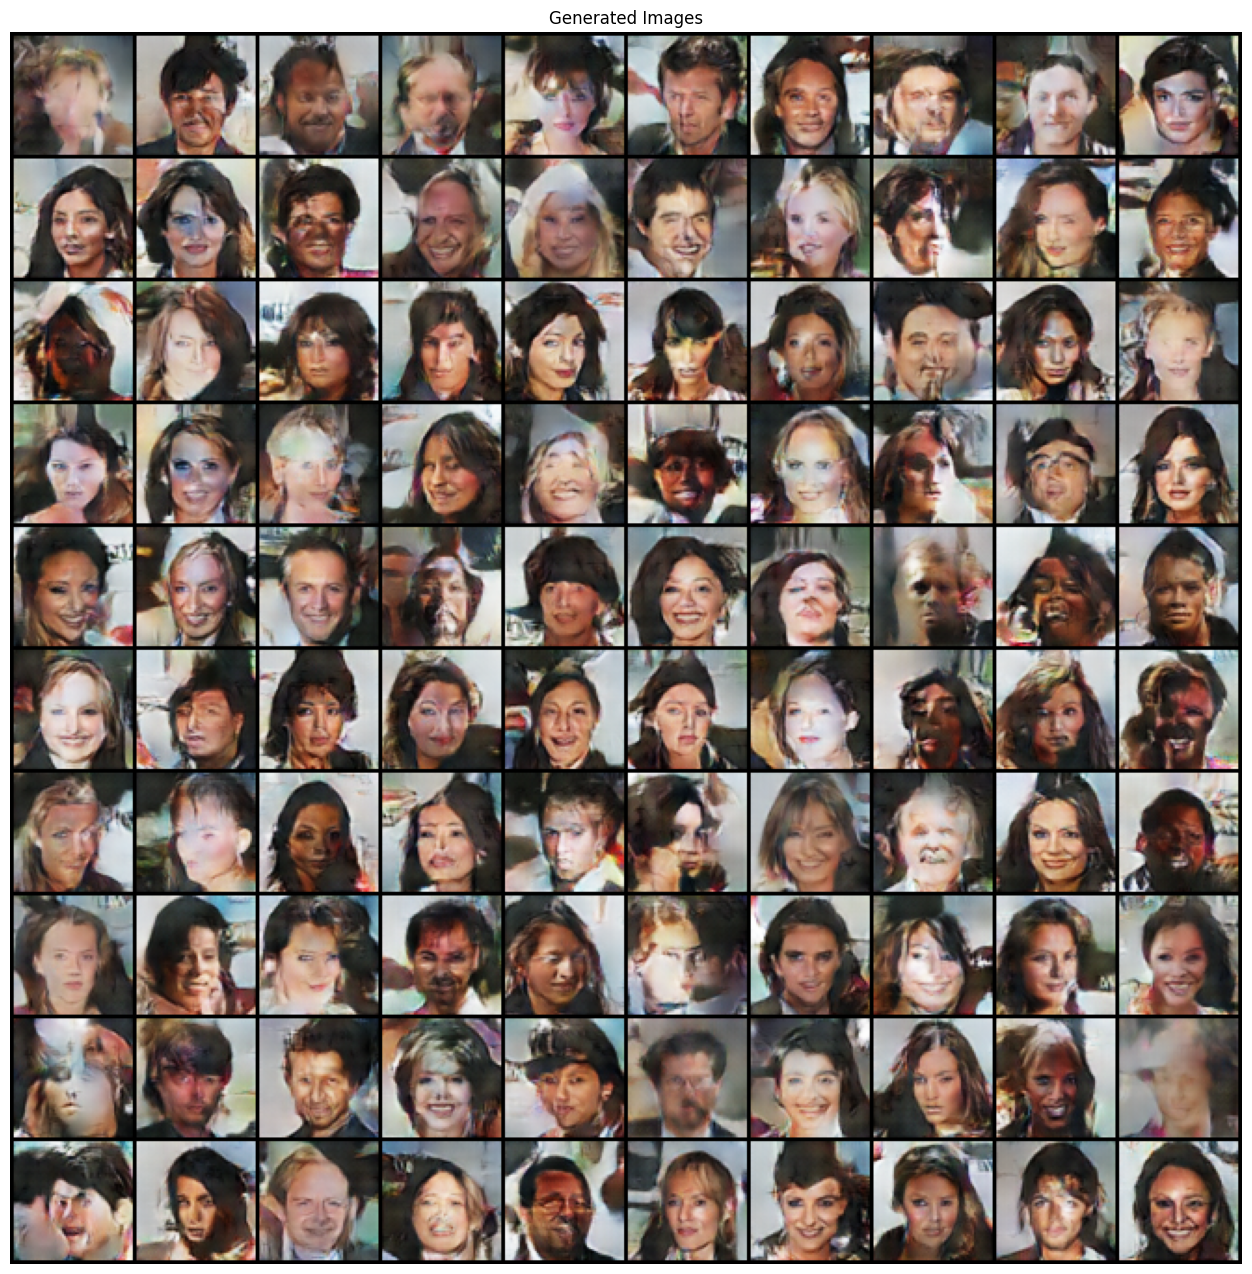

In [63]:
from torchvision.utils import  make_grid

num_options = 100
generated_imgs = []
latent_vectors = []
padding = 2
for i in range(num_options):
    latent_vector = torch.randn(1, params['nz'], 1, 1, device=device)
    with torch.no_grad():
      generated_img = netG(latent_vector).detach().cpu()
    generated_imgs.append(generated_img) 
    latent_vectors.append(latent_vector.detach().cpu())
stacked_tensor_imgs = torch.stack(generated_imgs).view(100, 3, 64, 64)
final_tensor_img = make_grid(stacked_tensor_imgs, nrow=int(np.sqrt(num_options)), padding=padding, normalize=True)
display_img = np.moveaxis(final_tensor_img.numpy(), 0, 2)

plt.figure(figsize = (16, 16))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(display_img);

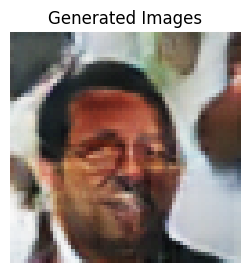

In [79]:
img_idx = 94
plt.figure(figsize = (3, 3))
plt.axis("off")
plt.title("Generated Images")
plt.imshow((np.moveaxis(stacked_tensor_imgs[img_idx].numpy(), 0, 2) + 1) / 2)

In [88]:
# Выделим индексы интересующих нас изображений
black_haired_woman_ix = [10, 24, 28, 39, 45]
white_haired_woman_ix = [14, 16, 36, 60, 95]
black_haired_man_ix = [1, 5, 8, 42, 94]

In [89]:
black_haired_woman_latent_vectors = [latent_vectors[i].numpy() for i in black_haired_woman_ix]
white_haired_woman_latent_vectors = [latent_vectors[i].numpy() for i in white_haired_woman_ix]
black_haired_man_latent_vectors = [latent_vectors[i].numpy() for i in black_haired_man_ix]

In [90]:
# Рассчитаем усредненный латентный вектор для каждой категории 
black_haired_woman_avg_latent_vector = np.mean(np.array(black_haired_woman_latent_vectors), axis=0)
white_haired_woman_avg_latent_vector = np.mean(np.array(white_haired_woman_latent_vectors), axis=0)
black_haired_man_avg_latent_vector = np.mean(np.array(black_haired_man_latent_vectors), axis=0)

In [91]:
white_haired_man_latent_vector = black_haired_man_avg_latent_vector + (
    white_haired_woman_avg_latent_vector - black_haired_woman_avg_latent_vector
    )

In [87]:
white_haired_man_latent_vector.shape

(1, 100, 1, 1)

In [92]:
with torch.no_grad():
      white_haired_women_imgs = np.hstack(
            [netG(torch.Tensor(white_haired_woman_latent_vector).cpu()).view(3, 64, 64).detach().cpu() 
             for white_haired_woman_latent_vector in white_haired_woman_latent_vectors]
            )
      black_haired_women_imgs = np.hstack(
            [netG(torch.Tensor(black_haired_woman_latent_vector).cpu()).view(3, 64, 64).detach().cpu() 
             for black_haired_woman_latent_vector in black_haired_woman_latent_vectors]
            )
      black_haired_men_imgs = np.hstack(
            [netG(torch.Tensor(black_haired_man_latent_vector).cpu()).view(3, 64, 64).detach().cpu() 
             for black_haired_man_latent_vector in black_haired_man_latent_vectors]
            ) 
      
      white_haired_woman_avg_img = netG(torch.Tensor(white_haired_woman_avg_latent_vector).cpu()).view(3, 64, 64).detach().cpu()
      black_haired_woman_avg_img = netG(torch.Tensor(black_haired_woman_avg_latent_vector).cpu()).view(3, 64, 64).detach().cpu()
      black_haired_man_avg_img = netG(torch.Tensor(black_haired_man_avg_latent_vector).cpu()).view(3, 64, 64).detach().cpu()
      white_haired_man_img = netG(torch.Tensor(white_haired_man_latent_vector).cpu()).view(3, 64, 64).detach().cpu()

Светловолосая женщина


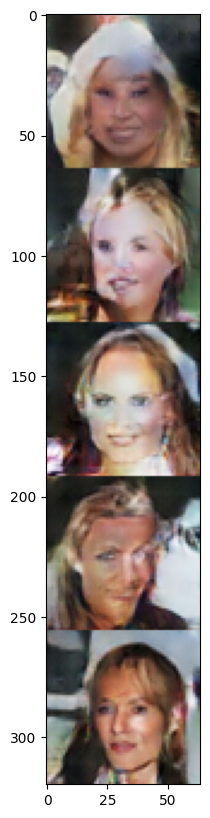

In [93]:
plt.figure(figsize = (10,10))
print('Светловолосая женщина')
plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(white_haired_women_imgs), padding=2, normalize=True, nrow=10), (1,2,0)));

Темноволосая женщина


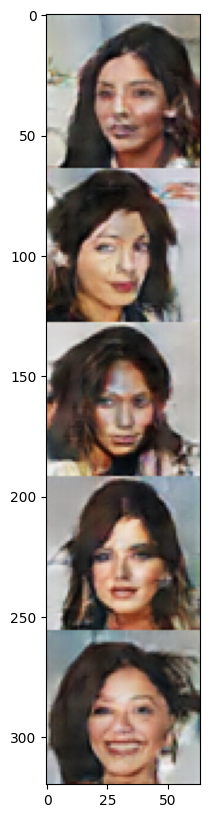

In [94]:
plt.figure(figsize = (10,10))
print('Темноволосая женщина')
plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(black_haired_women_imgs), padding=2, normalize=True, nrow=10), (1,2,0)));

Темноволосый мужчина


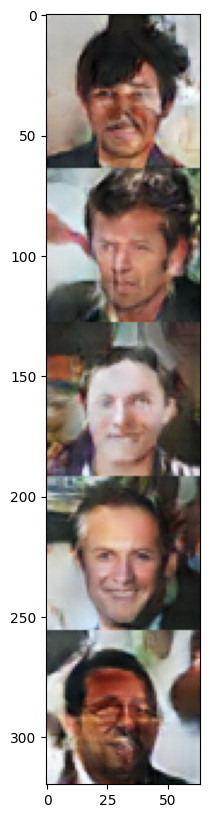

In [95]:
plt.figure(figsize = (10,10))
print('Темноволосый мужчина')
plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(black_haired_men_imgs), padding=2, normalize=True, nrow=10), (1,2,0)));

Резултьтат - светловолосый мужчина


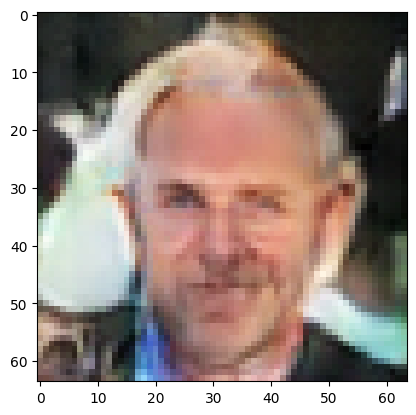

In [96]:
print('Резултьтат - светловолосый мужчина')

plt.imshow(np.transpose(
    vutils.make_grid(
        torch.Tensor(white_haired_man_img),
        padding=2, normalize=True, nrow=10
        ),
    (1, 2, 0)
    ));